In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo='418336'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

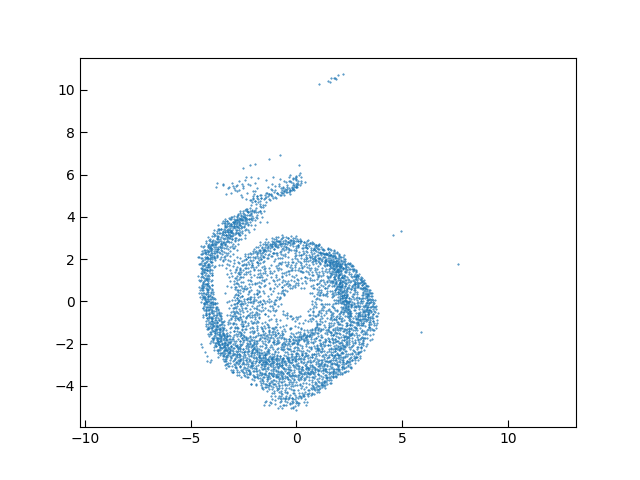

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


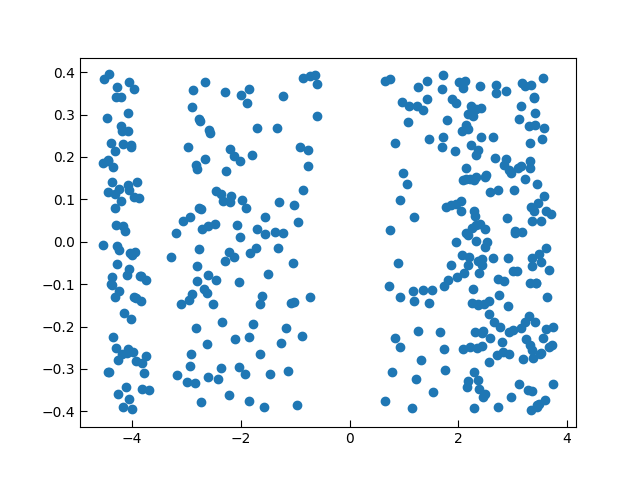

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


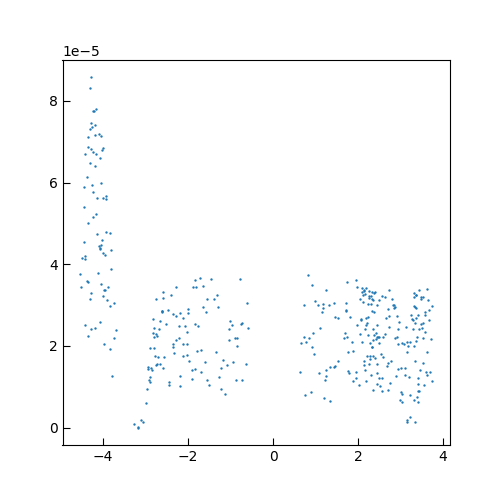

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

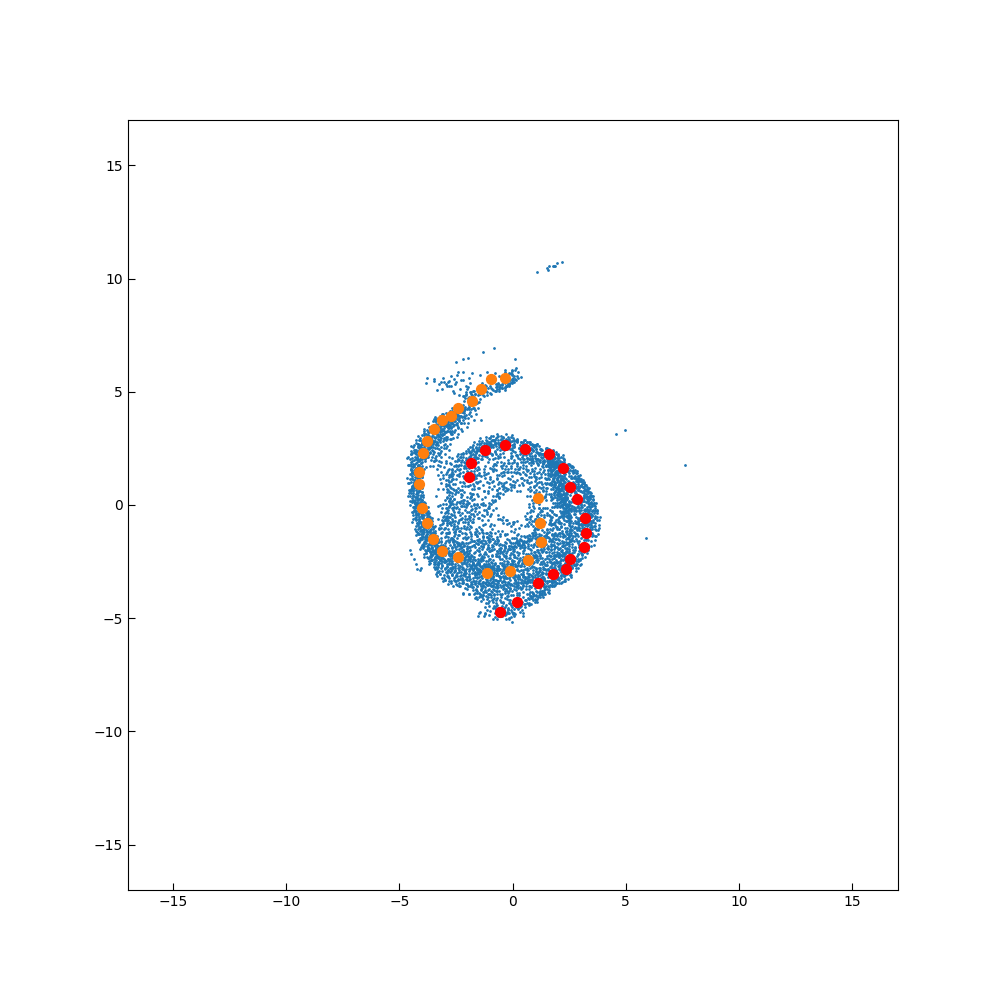

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 17
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [14]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [15]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [16]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [17]:
b = 0.3

In [18]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

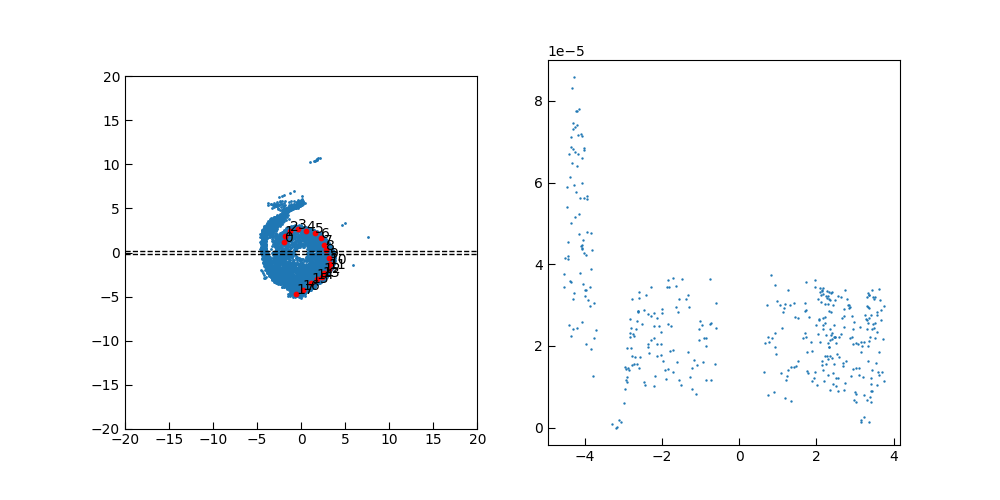

In [19]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

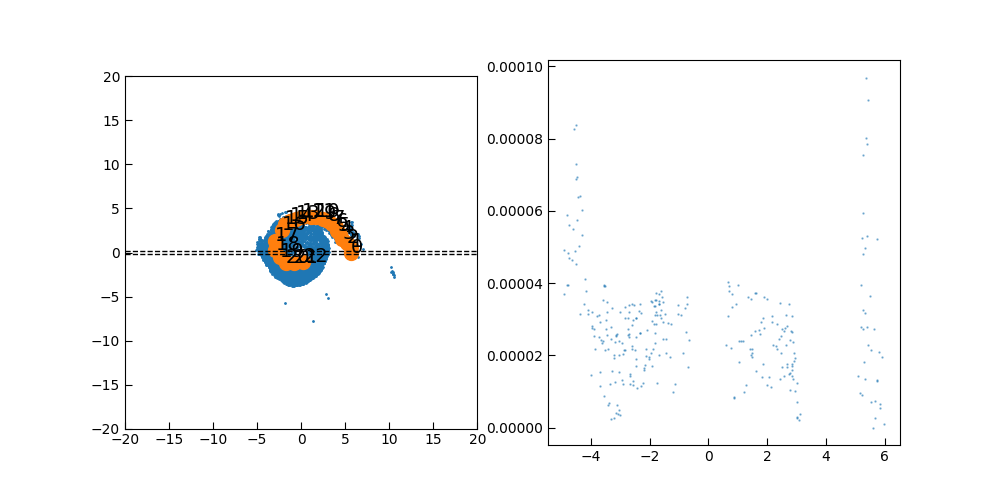

In [20]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [21]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [22]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [23]:
arm = df_arm2.copy(deep=True)

In [25]:
arm.head(3)

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-0.326299,5.606737,2,0,"({'x_rot': [0.3318741057510764, 0.605787933653...","{'x_rot': [0.3318741057510764, 0.6057879336533...",1.628928,"{'x_rot': [5.616223889346627, 5.61354641122684...","{'x_rot': 5.616223889346627, 'y_rot': 8.881784...","{'x_band': [0.605787933653359, 0.6554251283557..."
1,-0.949675,5.567776,2,1,"({'x_rot': [0.39406935547447614, 0.57570349273...","{'x_rot': [0.39406935547447614, 0.575703492732...",1.739737,"{'x_rot': [5.58177967015199, 5.648186657613048...","{'x_rot': 5.648186657613048, 'y_rot': 4.440892...","{'x_band': [0.6825174201602612, 0.677917465556..."
2,-1.378247,5.100244,2,2,"({'x_rot': [0.4435639277321146, 0.544277057393...","{'x_rot': [0.4435639277321146, 0.5442770573936...",1.834724,"{'x_rot': [5.497714349683767, 5.62272529888022...","{'x_rot': 5.283185396932838, 'y_rot': 1.332267...","{'x_band': [0.591946768591592, 0.6990871800107..."


(-2.5, 2.5)

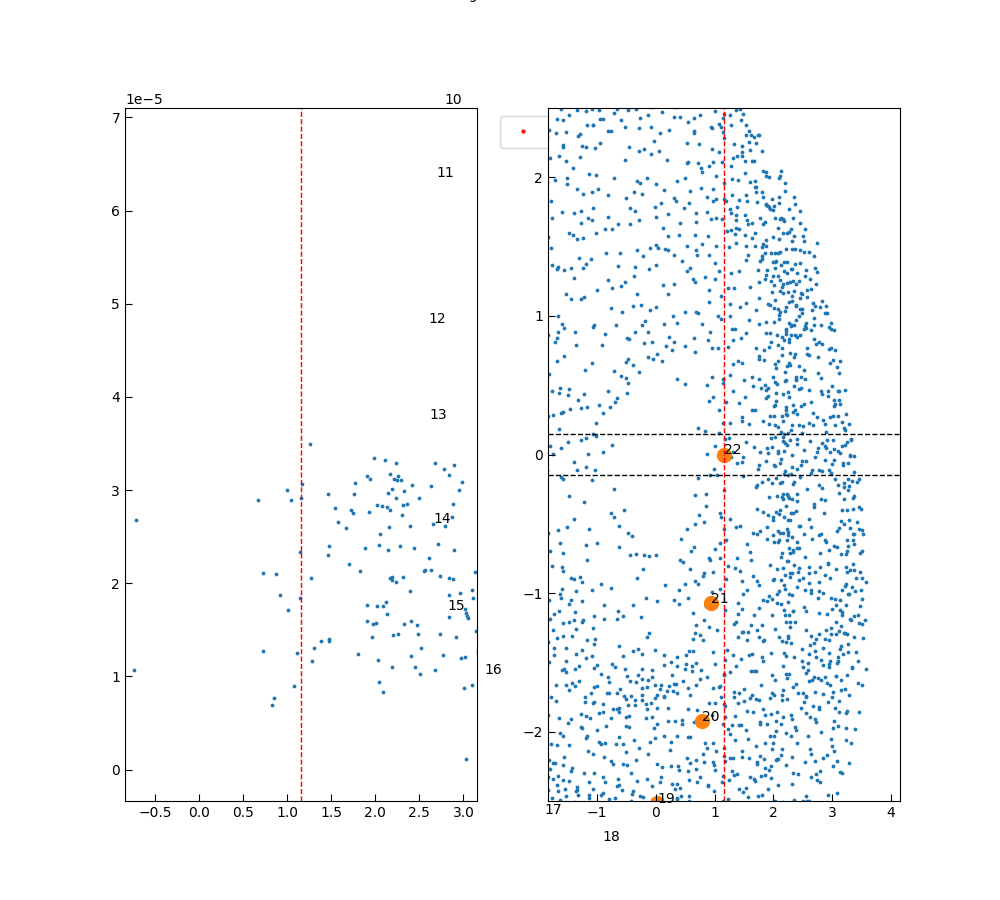

In [266]:
%matplotlib widget

n= 22 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [257]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [258]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(3.900909696150657e-12, 3.0026212987724886e-05)

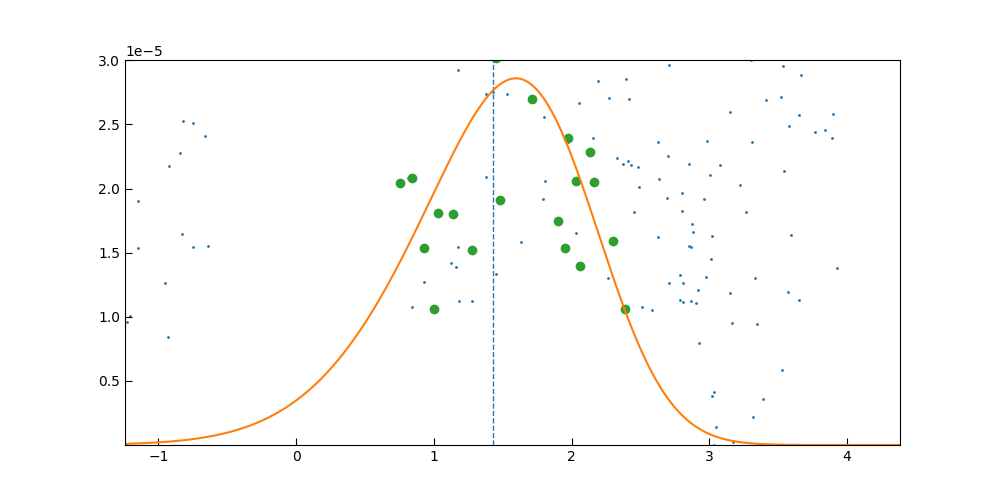

In [259]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [260]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [261]:
df_params.tail()

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
17,0.000112,3.993603,0.05,False,0.008904,17.0,1.251813,0.000077,49056.857126,49120.867013,350.125847,"[2.0651347554124397, 2.1637349487309128, 2.357...",-1.144481,"[7.930989949545837e-06, 1.6208744298518083e-05...",-3.003653
18,0.000069,1.939443,0.05,False,4.938808,18.0,1.880476,0.000022,0.219376,7.739174,0.939959,"[2.0205635413879466, 2.1620906757792664, 2.202...",-0.131494,"[1.8778661451377868e-05, 2.027598921232196e-05...",-2.925731
19,0.000062,2.060726,0.05,False,7.311691,19.0,1.711634,0.000009,0.069893,4.788189,0.372177,"[1.9761169213842633, 2.043048646248413, 2.1309...",0.686688,"[1.4320854290865623e-05, 1.564917559739499e-05...",-2.419237
20,0.000065,2.316169,0.05,False,-0.015649,20.0,0.859208,0.000004,2651.953104,3869.452565,33.098034,"[1.0955753112999989, 1.1669747285922893, 1.295...",1.271104,"[1.3513976461331413e-05, 1.7341425096965382e-0...",-1.640016
21,0.000047,2.105925,0.05,False,-1.955344,21.0,0.958953,0.000006,0.248916,2.513262,0.452729,"[0.7573055311898118, 0.8423405617712295, 0.929...",1.193182,"[2.042919744652176e-05, 2.0810863228313485e-05...",-0.782873


In [262]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [263]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [264]:
arm.iloc[n].id

21

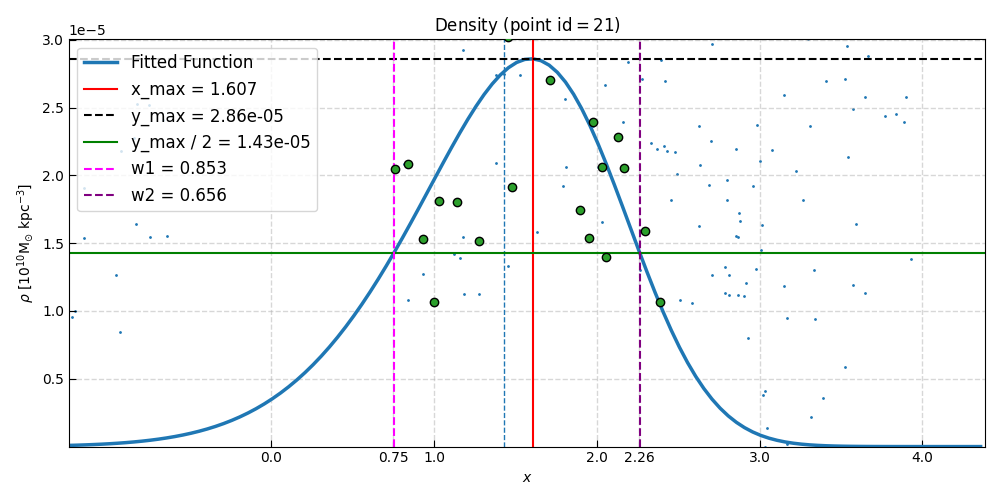

In [265]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

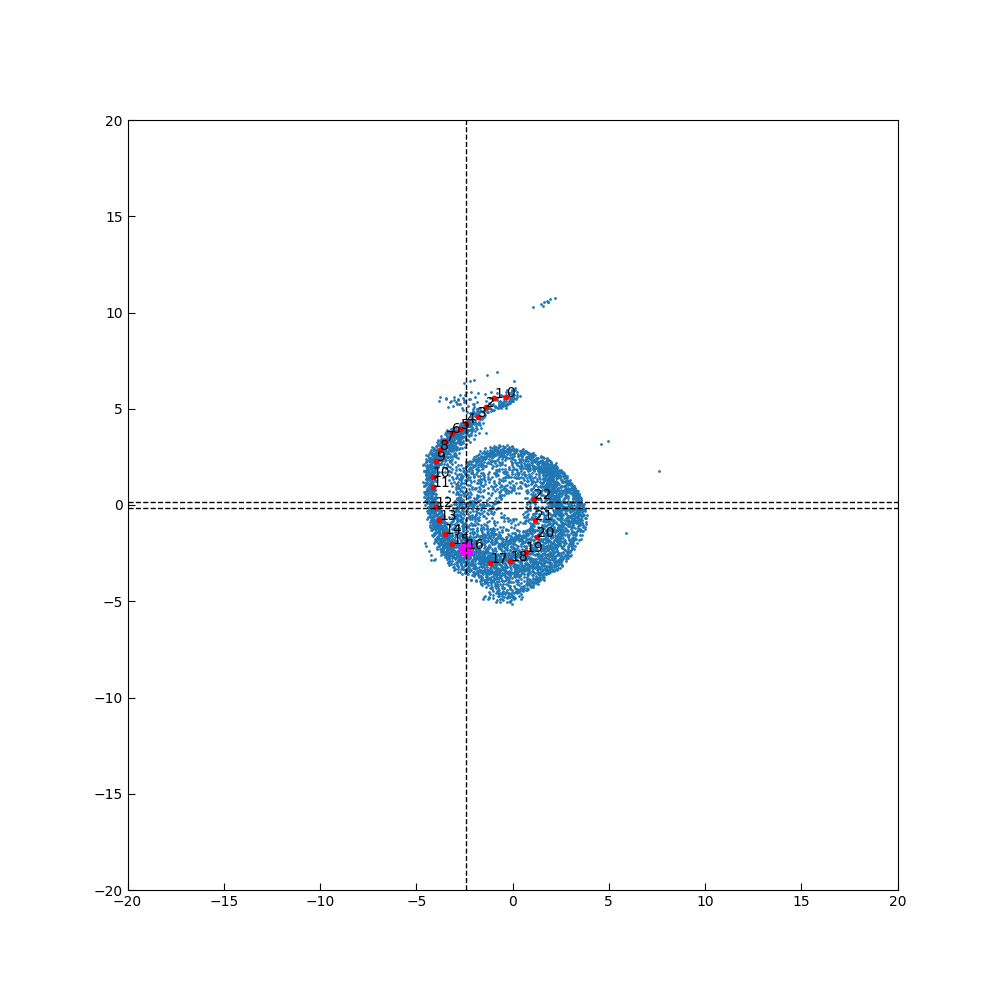

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [267]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [268]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

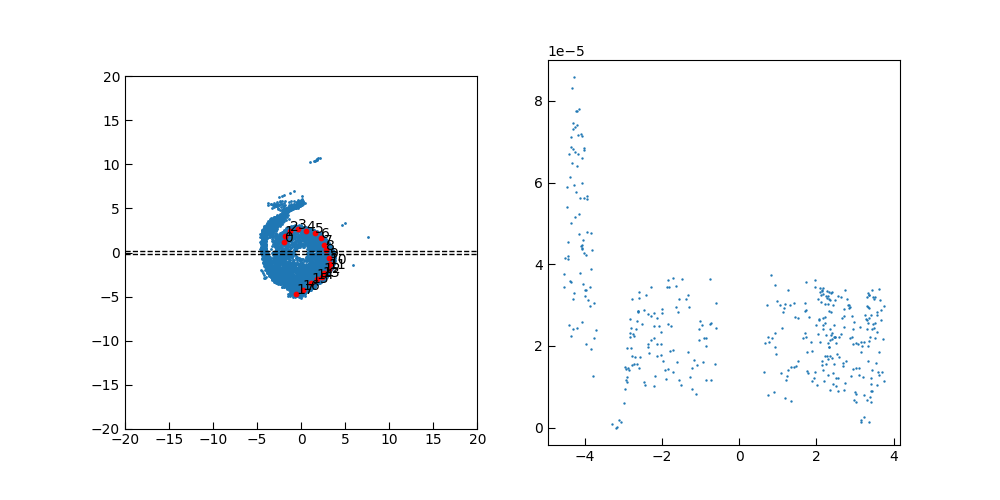

In [269]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [270]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [271]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-1.923701,1.243101,1,0,"({'x_rot': [0.6647214828023018, 0.165370577518...","{'x_rot': [0.6647214828023018, 0.1653705775183...",2.567892,"{'x_rot': [2.2903986358363646, 2.5632861031243...","{'x_rot': 2.2903986358363646, 'y_rot': -2.2204...","{'x_band': [0.6647214828023018, 0.638161881641..."
1,-1.845779,1.866477,1,1,"({'x_rot': [0.6328706403710975, 0.297220410200...","{'x_rot': [0.6328706403710975, 0.2972204102001...",2.350619,"{'x_rot': [2.2365490705779587, 2.6250025412307...","{'x_rot': 2.6250025412307294, 'y_rot': 6.66133...","{'x_band': [0.6328706403710975, 0.661088682602..."
2,-1.222403,2.411932,1,2,"({'x_rot': [0.5362788922580368, 0.460090586207...","{'x_rot': [0.5362788922580368, 0.4600905862072...",2.039881,"{'x_rot': [1.9784714818590552, 2.4992863080383...","{'x_rot': 2.7040124270599204, 'y_rot': -4.4408...","{'x_band': [0.6399013381259702, 0.713248597813..."
3,-0.326299,2.645698,1,3,"({'x_rot': [0.3686670561008517, 0.589136184146...","{'x_rot': [0.3686670561008517, 0.5891361841466...",1.693508,"{'x_rot': [1.4692223883701554, 2.0783734093896...","{'x_rot': 2.6657436156823, 'y_rot': 2.22044604...","{'x_band': [0.5891361841466349, 0.672215703894..."
4,0.569805,2.489854,1,4,"({'x_rot': [0.1564091586670797, 0.648283895184...","{'x_rot': [0.1564091586670797, 0.6482838951845...",1.345820,"{'x_rot': [0.7826273310737015, 1.4076775715605...","{'x_rot': 2.554222070214478, 'y_rot': 0.0}","{'x_band': [0.6482838951845015, -0.70788787447..."
5,1.621753,2.256088,1,5,"({'x_rot': [-0.10808898092581301, 0.6207132259...","{'x_rot': [-0.10808898092581301, 0.62071322594...",0.947541,"{'x_rot': [-0.11345177284168995, 0.43820105033...","{'x_rot': 2.778491521222788, 'y_rot': 0.0}","{'x_band': [0.6207132259445962, -0.68378290813..."
6,2.245130,1.632711,1,6,"({'x_rot': [-0.30954691535021334, 0.5279016024...","{'x_rot': [-0.30954691535021334, 0.52790160240...",0.628764,"{'x_rot': [-0.8246789385288052, -0.39502283436...","{'x_rot': 2.776031964962689, 'y_rot': 0.0}","{'x_band': [-0.6573061715032795, 0.74347106741..."
7,2.556818,0.814529,1,7,"({'x_rot': [-0.48055046320142886, 0.3810642716...","{'x_rot': [-0.48055046320142886, 0.38106427168...",0.308407,"{'x_rot': [-1.4556064223987788, -1.19214062746...","{'x_rot': 2.6834263668636833, 'y_rot': 0.0}","{'x_band': [0.7283143736152651, -0.73767586886..."
8,2.829545,0.269075,1,8,"({'x_rot': [-0.5682819016316679, 0.26051156212...","{'x_rot': [-0.5682819016316679, 0.260511562124...",0.094810,"{'x_rot': [-1.797380498233244, -1.660794811490...","{'x_rot': 2.8423104440296303, 'y_rot': 0.0}","{'x_band': [0.704908430354517, -0.741483966374..."
9,3.180195,-0.588068,1,9,"({'x_rot': [-0.6432621038754828, 0.08699226794...","{'x_rot': [-0.6432621038754828, 0.086992267942...",6.100335,"{'x_rot': [-2.1176689183531865, -2.15439636254...","{'x_rot': 3.234109334183828, 'y_rot': 5.551115...","{'x_band': [-0.6432621038754828, -0.6955256665..."


(-2.5, 2.5)

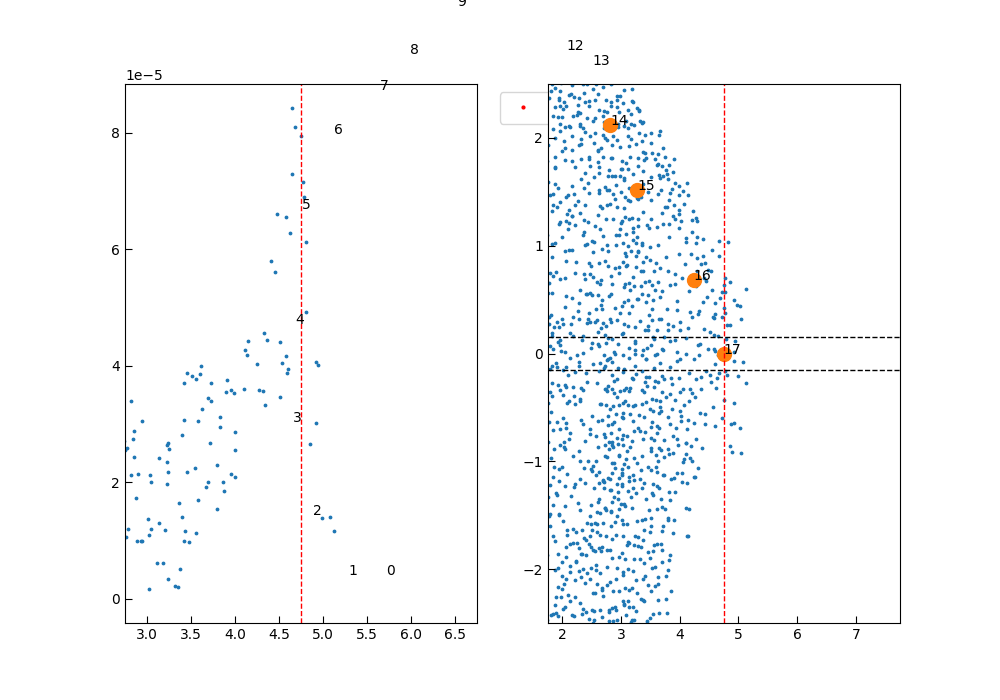

In [429]:
n= 17 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [430]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [431]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(0.0, 6.919970604924026e-05)

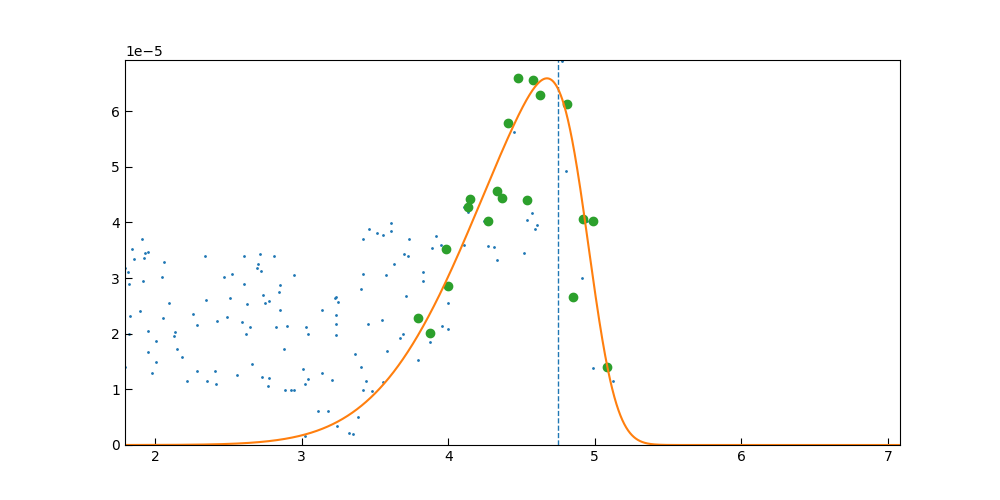

In [432]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [433]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [434]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000068,3.065634,0.05,False,-7.053630,0.0,1.749561,0.000008,0.051517,2.814693,0.285681,"[0.930161058695907, 1.1501515575441807, 1.2251...",-1.923701,"[8.431093497257162e-06, 1.9053676360018433e-05...",1.243101
1,0.000055,3.024764,0.05,False,-16.454760,1.0,1.511794,0.000010,0.029237,8.409464,0.359080,"[1.352420271861308, 1.785603231598143, 1.84240...",-1.845779,"[1.2892553254869941e-05, 1.6770316187792396e-0...",1.866477
2,0.000052,3.075053,0.05,False,-19.590814,2.0,1.404767,0.000006,0.020546,9.836535,0.224496,"[1.4482446353081517, 1.717248282027308, 1.7936...",-1.222403,"[1.0478769125488477e-05, 1.3645837889067874e-0...",2.411932
3,0.000041,2.968287,0.05,False,-14.223399,3.0,1.155108,0.000004,0.021170,6.682713,0.151802,"[1.2271548653340463, 1.62433466694541, 1.69840...",-0.326299,"[7.1152624427028665e-06, 1.2939142705295395e-0...",2.645698
4,0.000055,2.564958,0.05,False,0.041090,4.0,0.840902,0.000035,1371.885708,2050.019596,51.304301,"[1.2344969607324965, 1.7064588518468178, 1.811...",0.569805,"[6.5763466802385964e-06, 1.708931108604707e-05...",2.489854
5,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088
6,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088
7,0.000058,3.123517,0.05,False,-7.757767,6.0,1.317065,0.000004,0.046908,3.942511,0.104690,"[1.0664025388277603, 1.2476734431656324, 1.268...",2.245130,"[1.1080322456557369e-05, 1.7128725486020925e-0...",1.632711
8,0.000058,1.786908,0.05,False,4.715689,7.0,1.500044,0.000008,0.066392,2.664894,0.332100,"[1.6416074684001694, 1.6936437084365796, 1.834...",2.556818,"[9.335432745877142e-06, 1.3393178973385508e-05...",0.814529
9,0.000067,1.830593,0.05,False,1.928790,8.0,1.394173,0.000007,0.243776,1.658938,0.458043,"[1.3315129282609672, 1.4812994506835715, 1.725...",2.829545,"[6.355240525133809e-06, 1.4961756686899603e-05...",0.269075


In [435]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 6.59421e-05
center                                                        4.95128
delta                                                            0.05
fractured                                                       False
gamma                                                        -4.56446
id_tracing                                                         17
sigma                                                        0.712112
stderr_amplitude                                          5.54425e-06
stderr_center                                               0.0361358
stderr_gamma                                                  2.11632
stderr_sigma                                                0.0982508
x                   [3.794393851170632, 3.872662435912499, 3.98669...
x_tracing                                                   -0.560065
y                   [2.2897908523651877e-05, 2.0053903331272268e-0...
y_tracing           

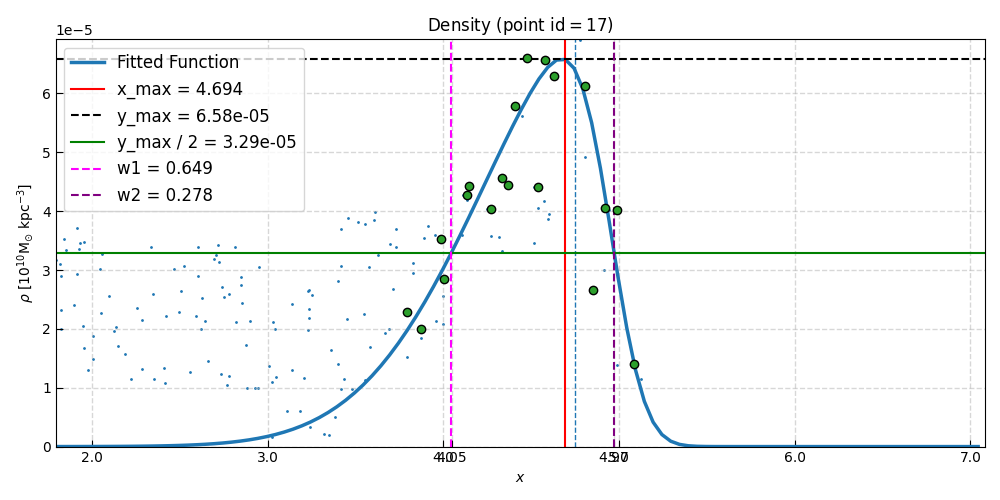

In [436]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

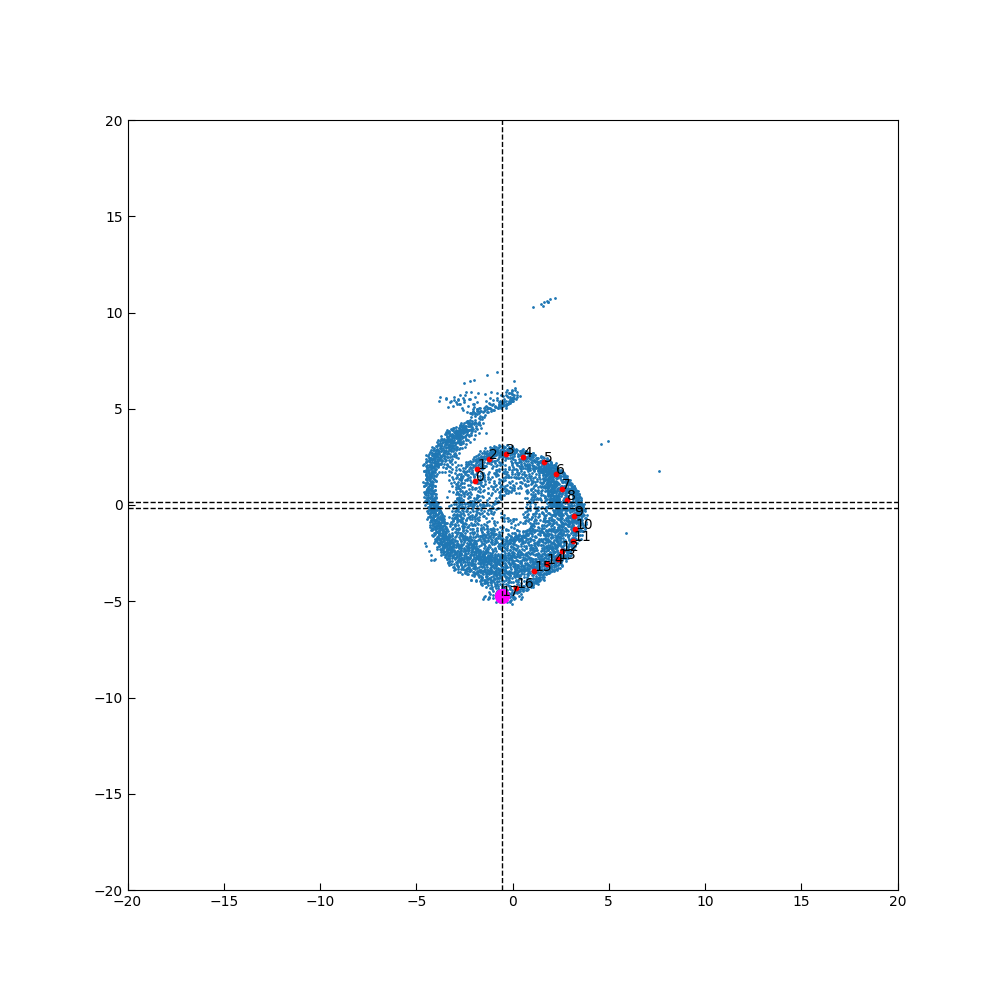

In [437]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [438]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')